# My first CTMC algorithm

My first attempt at fitting a Continous Time Markov Chain to simulated data in a toy problem. Mathematical background on how to build the likelihood can be found in [here](http://www.mathematik.uni-karlsruhe.de/ianm3/~jahnke/media/medijasc2007.pdf).

## First toy problem

In this toy problem, we begin with a simple 3 state model, where an individual can be either susceptible (S), depressed (D) or happy (H).

The transitions will be defined as follows:

\begin{align}
S \to D & &\text{with rate} & &\beta,\\
D \to H & &\text{with rate} & &\gamma,\\
H \to S & &\text{with rate} & &\omega.\\
\end{align}

(537, 6)


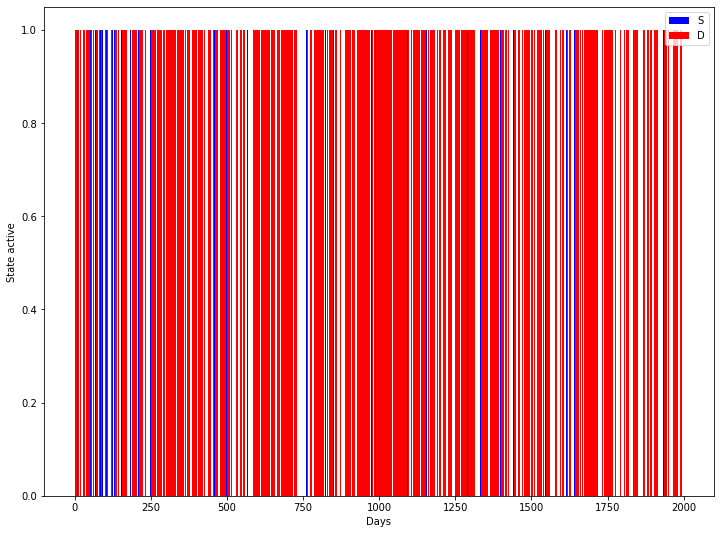

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f1a77ea47a2731335b05ae42817bae4 NOW.


Inference for Stan model: anon_model_5f1a77ea47a2731335b05ae42817bae4.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet    1.74  3.6e-3   0.13   1.49   1.65   1.73   1.82    2.0   1306    1.0
gamm   0.14  3.1e-4   0.01   0.12   0.14   0.14   0.15   0.16   1161    1.0
omeg   0.29  6.8e-4   0.02   0.24   0.27   0.29    0.3   0.33    997    1.0
lp__  -1018    0.05   1.27  -1021  -1018  -1017  -1017  -1016    577    1.0

Samples were drawn using NUTS at Wed Jan  8 14:39:12 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
(2, 0.125, 0.3)


In [245]:
class ctmc:    
    """Class object to contain the ctmc model"""
    import numpy as np
    
    def __init__(self,beta, gamma,omega,init):
        self.parameters = (beta,gamma,omega)
        self.initial = init
        self.current = list(init)
        self.totalpop = sum(init)
    
    def transition(self):
        #First define transition movements
        
        def depression():
            #being depressed
            self.current[0] -= 1
            self.current[1] += 1

        def recovery():
            #Recovery to happiness 
            self.current[1] -=1
            self.current[2] +=1
            
        def waning():
            #Recovery to happiness 
            self.current[2] -=1
            self.current[0] +=1

        #map the functions to the respective index in the transition
        map_transitions = {
            0 : depression,
            1 : recovery,
            2 : waning,
        }

        #Calculate transitions rates
        trans = beta * self.current[0]
        recov = gamma * self.current[1]
        wan  = omega * self.current[2]
        total = trans + recov + wan
        
        #Record current rates
        self.currentrates = (trans, recov, wan)
        
        #Draw a transition time
        dt = -1*np.log(np.random.random())/total#np.random.exponential(1/total) #numpy uses scale parameter, inverse of rate
        
        #Draw a transition
        p = np.array(self.currentrates)/total
        s = np.random.choice(3, p=p)
        map_transitions[s]() #map choice to correct transition function
        #return time to transition and what kind of transition occured
        return dt, s
    
    def simulate(self,simtime):
        time = 0
        observations = []
        while time < simtime:
            S,D,H = self.current.copy()
            dt, s = self.transition()

            time += dt
            if time > simtime:
                continue
            else:
                
                observations.append((time,dt,s,S,D,H))
        return observations

#Simulate a path in the CTMC
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


init = np.array((1,0,0))
beta = 2
gamma = 0.125
omega = 0.3
nu = 1

toy = ctmc(beta, gamma, omega,init)
obs = toy.simulate(2000)

data = pd.DataFrame(obs, columns = ['time','dt','transition','S','D','R'])
data.time = data.time.shift(1).fillna(0)
#print(data)
print(data.shape)
fig,ax = plt.subplots(figsize=(12,9))
ax.bar(data.time, data.S, width=data.dt, align='edge', label='S', color='b')
ax.bar(data.time, data.D, width=data.dt, align='edge', label='D', color = 'r')
ax.set_xlabel("Days")
ax.set_ylabel("State active")
plt.legend()
plt.show()

import pystan

stancode = """
data {
    int<lower=0> N; //length of data
    real<lower=0> dt[N]; //time
    int<lower=0> transitions[N]; //transition code
}
parameters {
    real<lower=0> bet;
    real<lower=0> gamm;
    real<lower=0> omeg;
}
model {
    //bet ~ gamma(1,1.5);
    //gamm ~ gamma(1.5,1.5);
    //omega ~ gamma(1.5,1.5);
    //nu ~ gamma(1.5,1.5);
    
    for (n in 1:N){
        if (transitions[n] == 0) {
            //Infection
            dt[n] ~ exponential(bet);
            }
        if (transitions[n] == 1) {    
            //Recovery
            dt[n] ~ exponential(gamm);
            }
        if (transitions[n] == 2) {
            dt[n] ~ exponential(omeg);
        }
    } 
}
"""

data_dict = {
    'N': data.shape[0],
    'dt': data['dt'].values,
    'transitions': data.transition.astype(int).values
}

sm = pystan.StanModel(model_code=stancode)
iterations = 1000
chains = 2

fit = sm.sampling(data=data_dict, iter=iterations, chains=chains)
print(fit)
print(toy.parameters)


## Simulate a (harder) toy problem

Now let us extend our simple 3 state CTMC model, before going into epidemic specific models.

We will model a single individual suffering from depression again, however, the individual can now also take precautionary measures (i.e. seek help), and move from being susceptible to happy with rate $\nu$.

The transitions will be defined as follows:

\begin{align}
S \to D & &\text{with rate} & &\beta,\\
D \to H & &\text{with rate} & &\gamma,\\
H \to S & &\text{with rate} & &\omega,\\
S \to H & &\text{with rate} & &\nu.\\
\end{align}

This time the CTMC is more complex, as when in state S, the chain can jump to either state D or state H. This needs to be accounted for in the likelihood, where a transition out of state S is an exponential clock of all the rates out of S, times the probability the transition ends up at specifically D or H.

For simplicity, we can define the set of parameters to be $\boldsymbol{\theta} = (\beta, \gamma, \omega, \nu)$. For our toy problem, let us set $\boldsymbol{\theta} = ( 2, 0.125, 0.3, 1)$, with an inital start point at S, i.e. $\boldsymbol{n} = (1,0,0)$. Note that our units of time are days.


In [258]:
class ctmc:    
    """Class object to contain the ctmc model"""
    import numpy as np
    
    def __init__(self,beta, gamma, omega, nu,init):
        self.parameters = (beta, gamma, omega,nu)
        assert len(init)==3, "Number of states given is not 3"
        self.initial = init
        self.current = list(init)
        self.totalpop = sum(init)
    
    def transition(self):
        #First define transition movements
        
        def depression():
            #being depressed
            self.current[0] -= 1
            self.current[1] += 1

        def recovery():
            #Recovery to happiness 
            self.current[1] -=1
            self.current[2] +=1
        def waning():
            #back to susceptible
            self.current[2] -=1
            self.current[0] +=1
        def vacc():
            #susceptible to happy
            self.current[0] -=1
            self.current[2] +=1

        #map the functions to the respective index in the transition
        map_transitions = {
            0 : depression,
            1 : recovery,
            2 : waning,
            3 : vacc,
        }

        #Calculate transitions rates
        trans = beta * self.current[0]
        recov = gamma * self.current[1]
        wane = omega * self.current[2]
        vac = nu * self.current[0]
        total = trans + recov + wane + vac
        
        #Record current rates
        self.currentrates = (trans, recov, wane, vac)
        
        #Draw a transition time
        dt = -1*np.log(np.random.random())/total#np.random.exponential(1/total) #numpy uses scale parameter, inverse of rate
        
        #Draw a transition
        p = np.array(self.currentrates)/total
        s = np.random.choice(4, p=p)
        map_transitions[s]() #map choice to correct transition function
        #return time to transition and what kind of transition occured
        return dt, s
    
    def simulate(self,simtime):
        time = 0
        observations = []
        while time < simtime:
            S,D,H = self.current.copy()
            dt, s = self.transition()

            time += dt
            if time > simtime:
                continue
            else:
                
                observations.append((time,dt,s,S,D,H))
        return observations

Now that we have our functions and simulation coded, let's run a simulation and observe a possible path for this kind of CTMC, or epidemic. Let's plot the path of the state space over 400 days.

(1521, 6)


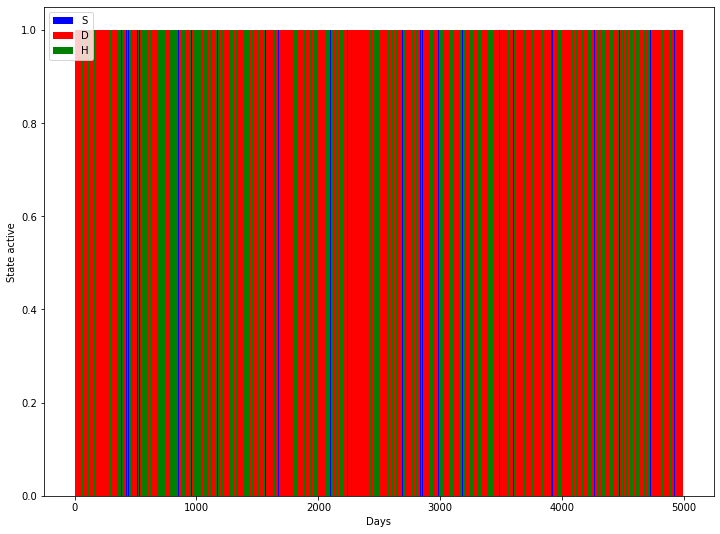

In [259]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


init = np.array((1,0,0))
beta = 2
gamma = 0.125
omega = 0.3
nu = 1

toy = ctmc(beta, gamma, omega,nu, init)
obs = toy.simulate(5000)

data = pd.DataFrame(obs, columns = ['time','dt','transition','S','D','H'])
data.time = data.time.shift(1).fillna(0)
#print(data)
print(data.shape)
fig,ax = plt.subplots(figsize=(12,9))
ax.bar(data.time, data.S, width=data.dt, align='edge', label='S', color='b')
ax.bar(data.time, data.D, width=data.dt, align='edge', label='D', color = 'r')
ax.bar(data.time, data.H, width=data.dt, align='edge', label='H', color='g')
ax.set_xlabel("Days")
ax.set_ylabel("State active")
plt.legend()
plt.show()

In [261]:
import pystan

stancode = """
functions {
    real ctmc_lpdf( real dt, real bet, real total) {
        return log(bet) - log(total) + exponential_lpdf( dt | total);
    } 
}
data {
    int<lower=0> N; //length of data
    real<lower=0> dt[N]; //time
    int<lower=0> transitions[N]; //transition code
}
parameters {
    real<lower=0> bet;
    real<lower=0> gamm;
    real<lower=0> omega;
    real<lower=0> nu;
}

model {
    bet ~ gamma(1.5,1.5);
    gamm ~ gamma(1.5,1.5);
    omega ~ gamma(1.5,1.5);
    nu ~ gamma(1.5,1.5);
    
    for (n in 1:N){
        if (transitions[n] == 0) {
            //Infection
            dt[n] ~ ctmc(bet, bet+nu);
            }
        else if (transitions[n] == 1) {    
            //Recovery
            dt[n] ~ exponential(gamm);
            }
        else if (transitions[n] == 2) {
            dt[n] ~ exponential(omega);
        }
        else if (transitions[n] == 3) {
            dt[n] ~ ctmc(nu, nu+bet);
        }
    } 
}
"""

data_dict = {
    'N': data.shape[0],
    'dt': data['dt'].values,
    'transitions': data.transition.astype(int).values
}

sm = pystan.StanModel(model_code=stancode)
iterations = 1000
chains = 2

fit = sm.sampling(data=data_dict, iter=iterations, chains=chains)
print(fit)
print(toy.parameters)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ba22c6371d7995b22bda91611fdd65f5 NOW.


Inference for Stan model: anon_model_ba22c6371d7995b22bda91611fdd65f5.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet     2.01  3.2e-3    0.1   1.81   1.94   2.01   2.08   2.23   1025    1.0
gamm    0.13  2.0e-4 6.7e-3   0.12   0.12   0.13   0.13   0.14   1161    1.0
omega   0.31  3.9e-4   0.01   0.28    0.3   0.31   0.32   0.33   1136    1.0
nu      1.05  2.1e-3   0.07   0.91    1.0   1.05    1.1   1.19   1205    1.0
lp__   -2708    0.06   1.36  -2711  -2709  -2708  -2707  -2706    527    1.0

Samples were drawn using NUTS at Wed Jan  8 15:14:52 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
(2, 0.125, 0.3, 1)


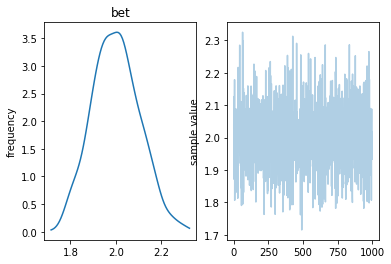

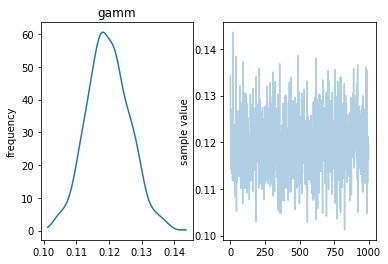

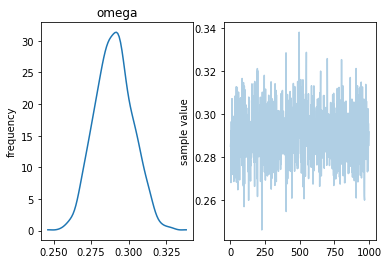

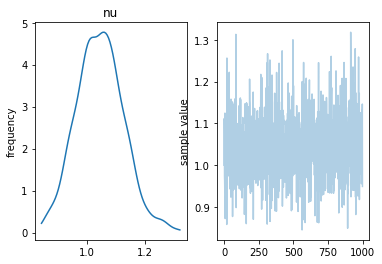

In [256]:
fit.plot(pars=['bet'])
fit.plot(pars=['gamm'])
fit.plot(pars=['omega'])
fit.plot(pars=['nu'])
plt.show()

### Maximum Likelihood Estimate

We know from our mathematical source (equation 13) that the Maximum Likelihood Estimate for the rates $r_{i,j}$ are:

\begin{align}
\hat{r_{i,j}} & = \frac{N_{i,j}} {\sum dt_{i} }\\
\end{align}

where $N_{i,j}$ is the number of transitions from i to j in the data, and $\sum dt_i$ is the total length of time spent in state i.

In [257]:
##MLE
bet_hat = data.loc[data.transition==0].S.sum()/data.loc[data.S==1].dt.sum()
gamm_hat = data.loc[data.transition==1].D.sum() /data.loc[data.D==1].dt.sum()
omeg_hat = data.loc[data.transition==2].H.sum() / data.loc[data.H==1].dt.sum()
nu_hat = data.loc[data.transition==3].S.sum() /data.loc[data.S==1].dt.sum() 
print(bet_hat, gamm_hat, omeg_hat, nu_hat)
print(toy.parameters)

2.0038726719748454 0.11897540027546838 0.2893561578593139 1.044511534400486
(2, 0.125, 0.3, 1)


## Simulate epidemic problem

First we will simulate some data. We will use a a simple 3 state model, a typical SIRS epidemic model with perfect vaccination, on a closed population of 100 people.

The transitions will be defined as follows:

\begin{align}
S \to I & &\text{with rate} & &\beta \frac{SI}{N},\\
I \to R & &\text{with rate} & &\gamma I,\\
R \to S & &\text{with rate} & &\omega R.\\
\end{align}

For simplicity, we can define the set of parameters to be $\boldsymbol{\theta} = (\beta, \gamma, \omega)$. For our toy problem, let us set $\boldsymbol{\theta} = ( 2, 0.125, 1/400)$, with an initial state (starting population) completely susceptible with 1 infected seed, i.e. $\boldsymbol{n} = (95,5, 0)$. Note that our units of time are days.

In [232]:
class sirvs:
    
    """Class object to contain the ctmc model"""
    import numpy as np
    
    def __init__(self,beta, gamma, omega, init):
        self.parameters = (beta, gamma, omega)
        assert len(init)==3, "Number of states given is not 3"
        self.initial = init
        self.current = list(init)
        self.totalpop = sum(init)
    
    def transition(self):
        #First define transition movements
        #0 = S, 1 = I, 2 = R, 3 = V 
        def infection():
            #Infected transmission
            self.current[0] -= 1
            self.current[1] += 1

        def recovery():
            #Recovery 
            self.current[1] -=1
            self.current[2] +=1
        def waning():
            #waning immunity
            self.current[2] -=1
            self.current[0] +=1
        def vacc():
            #vaccination
            self.current[0] -=1
            self.current[3] +=1

        #map the functions to the respective index in the transition
        map_transitions = {
            0 : infection,
            1 : recovery,
            2 : waning,
            3 : vacc,
        }

        #Calculate transitions rates
        trans = beta * self.current[0]*self.current[1]/self.totalpop
        recov = gamma * self.current[1]
        wane = omega * self.current[2]
        #vac = nu * self.current[1] * self.current[0]/self.totalpop
        total = trans + recov + wane #+ vac
        
        #Record current rates
        self.currentrates = (trans, recov, wane)
        
        #Draw a transition time
        dt = -1*np.log(np.random.random())/total#np.random.exponential(1/total) #numpy uses scale parameter, inverse of rate
        
        #Draw a transition
        p = np.array(self.currentrates)/total
        s = np.random.choice(3, p=p)
        map_transitions[s]() #map choice to correct transition function
        #return time to transition and what kind of transition occured
        return dt, s
    
    def simulate(self,simtime):
        time = 0
        observations = []
        while time < simtime:
            S,I,R = self.current.copy()
            dt, s = self.transition()

            time += dt
            if time > simtime:
                continue
            else:
                
                observations.append((time,dt,s,S,I,R))
        return observations

Now that we have our functions and simulation coded, let's run a simulation and observe a possible path for this kind of CTMC, or epidemic. Let's see how the state space looks after 20 days.

           time        dt  transition   S   I   R
1065  99.720824  0.153753           2   9  27  64
1066  99.748627  0.027804           2  10  27  63
1067  99.913229  0.164601           2  11  27  62
1068  99.944853  0.031624           2  12  27  61
1069  99.980599  0.035746           0  13  27  60
(1070, 6)


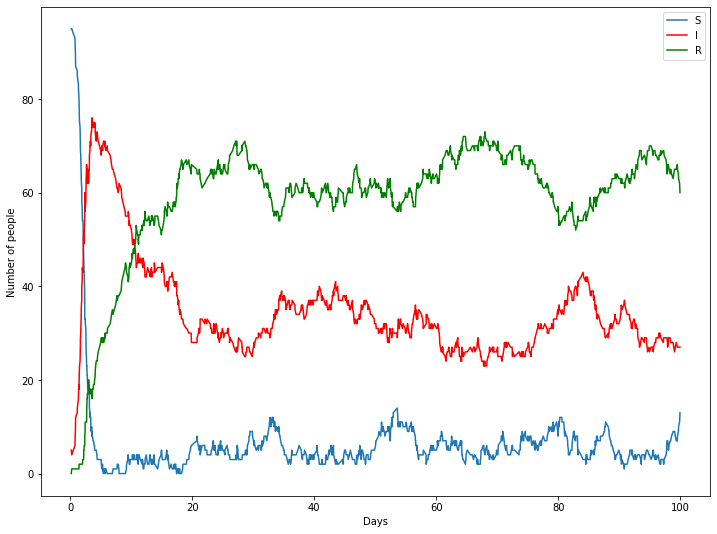

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


init = np.array((95,5,0))
beta = 2
gamma = 0.125
omega = 1/20

toy = sirvs(beta, gamma, omega, init)
obs = toy.simulate(100)

data2 = pd.DataFrame(obs, columns = ['time','dt','transition','S','I','R'])
print(data2.tail())
print(data2.shape)
fig,ax = plt.subplots(figsize=(12,9))
ax.plot(data2.time, data2.S, label='S')
ax.plot(data2.time, data2.I, label='I', color = 'r')
ax.plot(data2.time, data2.R, label='R', color='g')
ax.set_xlabel("Days")
ax.set_ylabel("Number of people")
plt.legend()
plt.show()

Now that we have our data, let's see how we would do inference. As a reminder, the parameters we want to be inferring are $\boldsymbol{\theta} = (\beta, \gamma, \omega)$.

In [239]:
import pystan

stancode = """
functions {
    real ctmc_lpdf( real dt, real bet, real total) {
        return log(bet) - log(total) + exponential_lpdf( dt | total);
    }   
}
data {
    int<lower=0> N; //length of data
    int<lower=1> Pop; //total size of population
    real<lower=0> dt[N]; //time
    int<lower=0> Sus[N];
    int<lower=0> I[N];
    int<lower=0> R[N];
    int<lower=0> transitions[N]; //transition code
}
parameters {
    real<lower=0> bet;
    real<lower=0> gamm;
    real<lower=0> omega;
}
model {
    int state;
    real total;
    bet ~ gamma(1,1.5);
    gamm ~ gamma(1,1.5);
    omega ~ gamma(1,1.5);
    
    for (n in 1:N){
        state = transitions[n];
        total = bet*Sus[n]*I[n] / Pop + gamm*I[n] + omega*R[n];
        if (state == 0) {
            //Infection
            dt[n] ~ ctmc(
            bet*Sus[n]*I[n] / Pop, 
            total
            );
            }
        else if (state == 1) {    
            //Recovery
            dt[n] ~ ctmc(
                gamm * I[n],
                total
            );
            }
        else if (state == 2) {
            //Waning
            dt[n] ~ ctmc(
                omega * R[n],
                total
            );
            }
    } 
}
"""

data_dict = {
    'N': data2.shape[0],
    'Pop': sum(init),
    'dt': data2['dt'].values,
    'Sus': data2.S.values.astype(int),
    'I': data2.I.values.astype(int),
    'R': data2.R.values.astype(int),
    'transitions': data2.transition.astype(int)
}

sm = pystan.StanModel(model_code=stancode)
iterations = 1000
chains = 2

fit = sm.sampling(data=data_dict, iter=iterations, chains=chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ffd571e602e697a4bdd265537910246 NOW.


Inference for Stan model: anon_model_3ffd571e602e697a4bdd265537910246.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bet     1.91  3.5e-3    0.1   1.73   1.85   1.92   1.98    2.1    758    1.0
gamm    0.11  1.6e-4 5.4e-3    0.1    0.1   0.11   0.11   0.12   1165    1.0
omega   0.05  1.0e-4 3.0e-3   0.05   0.05   0.05   0.06   0.06    887    1.0
lp__  463.53    0.05   1.21 460.31 463.08 463.84 464.37 464.88    567    1.0

Samples were drawn using NUTS at Wed Jan  8 14:21:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


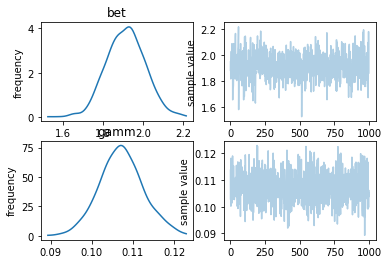

In [241]:
print(fit)
fit.plot(pars=['bet','gamm'])

plt.show()

In [236]:
##Finding an MLE here is difficult, due to the the transition rates being dependent on the state space (S,I,R)
toy.parameters

(2, 0.125, 0.05)